# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Introduction

The traffic-sign classifier project deals with classifying German traffic signs from their images usingDeep Learning techniques. Building a deep Convolutional Neural Network model is essential toclassify traffic signs for this project. Important steps in completing this projects are as follows.

1. Load the German traffic-sign data-set and identify training, validation and test sets
2. Explore, summarize and visualize the data-set
3. Pre-process the data-set (augment, normalize, grayscale etc.)
4. Design a deep learning model using tensorflow
5. Train and test the model architecture using training and validation data-set
6. Use the model to make predictions on test set as well as new images
7. Analyze softmax probabilities for new images
8. Summarize the results

As a first step to develop code for this project, it is important to import necessary packages inpython.

## Import Packages

In [2]:
import pickle
import numpy as np
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
import random
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

In [4]:
## Hyperparameters
no_channels = 1
EPOCHS = 15
BATCH_SIZE = 64
dropout = 0.6

---
## Step 0: Load The Data

The traffic signs images used in this project are from the German traffic sign dataset. The dataset is divided into 3 sets viz. training, validation and test sets. A quick summary of the dataset is provided in this section. The training set has more than 30000 examples available and each image is color image with RGB channels.

In [5]:
# Load pickled data

training_file = './traffic_sign_data/traffic-signs-data/train.p'
validation_file= './traffic_sign_data/traffic-signs-data/valid.p'
testing_file = './traffic_sign_data/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [6]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# Shape of the traffic sign image
image_shape = X_train[0].shape

# Shape of Lables
label_shape = y_train.shape

# Unique classes/labels in the dataset
unique_labels, counts_per_label = np.unique(y_train, return_counts = True)
n_classes = len(unique_labels)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

[Text(0, 0.5, 'Image Count'), Text(0.5, 0, 'Sign Number')]

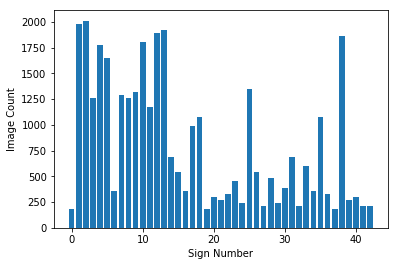

In [7]:
fig, ax = plt.subplots()
ax.bar(range(len(unique_labels)), counts_per_label)
ax.set(xlabel = 'Sign Number', ylabel = 'Image Count')

# Step 2: Preprocessig Dataset

### Leveling the Dataset

As seen in previous cell, the dataset has high variability in terms of number of training examples available per class. To level the dataset, a threshold of 1500 images was selected and for the classes with examples less than that, images were added by randomly duplicating training images. Though this method works well for this dataset, an online article mentioned that it maynot be a good idea as the variability in the original training dataset can be representative of the occurance of that particular class in real world.

In [8]:
threshold = 1500
for i in range(n_classes):
    if counts_per_label[i]<threshold:
        img_arr = X_train[y_train == i]
        diff_count = threshold - counts_per_label[i]
        rand_idx = (np.random.rand(diff_count)*(len(img_arr)-1)//1).astype(int)
        append_arr = img_arr[rand_idx]
        append_label = np.ones(diff_count)*i
        X_train = np.concatenate((X_train, append_arr))
        y_train = np.concatenate((y_train, append_label))
unique_labels, counts_per_label = np.unique(y_train, return_counts = True)

Training X Length 67380 Training y Length 67380


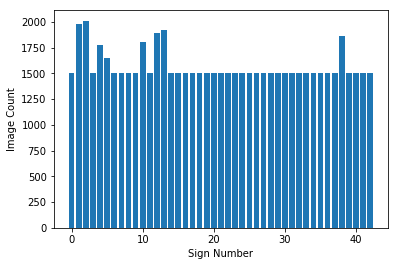

In [9]:
fig, ax = plt.subplots()
ax.bar(range(len(unique_labels)), counts_per_label)
ax.set(xlabel = 'Sign Number', ylabel = 'Image Count')

print('Training X Length', len(X_train), 'Training y Length', len(y_train))

### Grayscaling
Once the dataset is levelled, the images are grayscaled to reduce feature maps and thereby reduce datapoints. Python OpenCV library is used to convert RGB images to grayscale images.

In [10]:
X_train_gray = np.zeros((len(X_train), 32, 32, 1))
for i in range(len(X_train)):
    X_train_gray[i,:,:,0] = cv2.cvtColor(X_train[i], cv2.COLOR_RGB2GRAY)   

X_valid_gray = np.zeros((len(X_valid), 32, 32, 1))
for i in range(len(X_valid)):
    X_valid_gray[i,:,:,0] = cv2.cvtColor(X_valid[i], cv2.COLOR_RGB2GRAY) 
    
X_test_gray = np.zeros((len(X_test), 32, 32, 1))
for i in range(len(X_test)):
    X_test_gray[i,:,:,0] = cv2.cvtColor(X_test[i], cv2.COLOR_RGB2GRAY) 

### Dataset Augmentation

The next step in pre-processing the data is to augment the dataset by rotating and translating existing images. Such kind of augmentation prevents the neural network model from over-fitting the data. For each image, the angle of rotation is randomly chosen between $-10^{\circ}$ and $10^{\circ}$. Also, the images are translated by 3 pixels in x and y direction, but the sign is chose in a sequential manner. The dataset is augmented by 3 times its original number by rotating, translating and rotating as well translating every image. Following cell just shows an example of different ways used for augmentation and preprocessing.

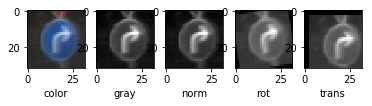

In [11]:
img_idx = 58032
image_color = X_train[img_idx]
image_gray = X_train_gray[img_idx].squeeze()
image_norm = (image_gray-128)/128

M = cv2.getRotationMatrix2D((16,16),10,1)
image_rot = cv2.warpAffine(image_gray,M,(32,32))

M_t = np.float32([[1,0,3],[0,1,3]])
image_trans = cv2.warpAffine(image_gray,M_t,(32,32))

img_arr = [image_color, image_gray, image_norm, image_rot, image_trans]
fig, axarr = plt.subplots(1,5)
labels = ['color', 'gray', 'norm', 'rot', 'trans']
for i in range(5):
    if i == 0:
        axarr[i].imshow(img_arr[i])
    else:
        axarr[i].imshow(img_arr[i], cmap='gray')
    axarr[i].set_xlabel(labels[i])

#### Rotation

In [12]:
rot_arr = (np.random.rand(len(X_train_gray))*20-10)//1
new_img_arr, new_y_arr = [], []
X_train_gray_copy = np.copy(X_train_gray)
y_train_copy = np.copy(y_train)
for i, img in enumerate(X_train_gray_copy):
    M = cv2.getRotationMatrix2D((16,16),rot_arr[i],1)
    dst = cv2.warpAffine(img,M,(32,32))
    dst = np.expand_dims(dst, axis=2)
    new_img_arr += [dst]
    new_y_arr += [y_train_copy[i]]
new_img_arr = np.array(new_img_arr)
new_y_arr = np.array(new_y_arr)
X_train_gray = np.append(X_train_gray, new_img_arr, axis=0)
y_train = np.append(y_train, new_y_arr, axis=0)
print(len(X_train_gray), len(y_train))

134760 134760


#### Translation

In [13]:
# X_train_gray_copy = np.copy(X_train_gray)

trans_x = [3, 3, -3, -3]
trans_y = [3, -3, 3, -3]
new_trans_X, new_trans_y = [], []

for i, img in enumerate(X_train_gray_copy):
    M_t = np.float32([[1,0,i%4],[0,1,i%4]])
    dst = cv2.warpAffine(img,M_t,(32,32))
    dst = np.expand_dims(dst, axis=2)
    new_trans_X += [dst]
    new_trans_y += [y_train_copy[i]]
new_trans_X = np.array(new_trans_X)
new_trans_y = np.array(new_trans_y)
X_train_gray = np.append(X_train_gray, new_trans_X, axis=0)
y_train = np.append(y_train, new_trans_y, axis=0)
print(len(X_train_gray), len(y_train))

202140 202140


#### Rotation + Translation

In [14]:
# X_train_gray_copy = np.copy(X_train_gray)
# y_train_copy = np.copy(y_train)

trans_x = [3, 3, -3, -3]
trans_y = [3, -3, 3, -3]
new_X, new_y = [], []

rot_arr = (np.random.rand(len(X_train_gray_copy))*20-10)//1
for i, img in enumerate(X_train_gray_copy):
    M = cv2.getRotationMatrix2D((16,16),rot_arr[i],1)
    M_t = np.float32([[1,0,i%4],[0,1,i%4]])
    dst = cv2.warpAffine(img,M,(32,32))
    dst = cv2.warpAffine(img,M_t,(32,32))
    dst = np.expand_dims(dst, axis=2)
    new_X += [dst]
    new_y += [y_train_copy[i]]
new_X = np.array(new_X)
new_y = np.array(new_y)
X_train_gray = np.append(X_train_gray, new_X, axis=0)
y_train = np.append(y_train, new_y, axis=0)
print(len(X_train_gray), len(y_train))

269520 269520


### Normalizing and Shuffling

In [15]:
def normalize_data(X):
    return (X - 128)/128

def shuffle_data(X, y):
    X, y = shuffle(X, y)
    return X, y

In [16]:
## Select appropriate data based on No. of Channels
if no_channels == 3:
    train_X = X_train
    train_y = y_train
    valid_X = X_valid
    valid_y = y_valid
    test_X = X_test
    test_y = y_test
elif no_channels == 1:
    train_X = X_train_gray
    train_y = y_train
    valid_X = X_valid_gray
    valid_y = y_valid
    test_X = X_test_gray
    test_y = y_test

In [17]:
train_X = normalize_data(train_X)
valid_X = normalize_data(valid_X)
test_X = normalize_data(test_X)

train_X, train_y = shuffle_data(train_X, train_y)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Model Architecture

In [18]:
def conv2d(x, W, b, stride = 1, pad = 'VALID'):
    x = tf.nn.conv2d(x, W, strides = [1,stride,stride,1], padding = pad)
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

In [19]:
def maxpool2d(x, k = 2, stride = 2):
    return tf.nn.max_pool(x, ksize = [1,k,k,1], strides = [1, stride, stride, 1], padding = 'SAME')

In [20]:
from tensorflow.contrib.layers import flatten

def LeNet(x, in_channels = 3, drop_out = 1.):
    ## Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    ## Define no. of channels in each layer
    channels = [10, 20, 500, 240, 168, 43]
    
    ## Define nomralized weights and biases
    weights = {
        'wc1': tf.Variable(tf.truncated_normal([5,5,in_channels,channels[0]], mean = mu, stddev = sigma)),
        'wc2': tf.Variable(tf.truncated_normal([5,5,channels[0],channels[1]], mean = mu, stddev = sigma)),
        'wd1': tf.Variable(tf.truncated_normal([channels[2],channels[3]], mean = mu, stddev = sigma)),
        'wd2': tf.Variable(tf.truncated_normal([channels[3],channels[4]], mean = mu, stddev = sigma)),
        'out': tf.Variable(tf.truncated_normal([channels[4],channels[5]], mean = mu, stddev = sigma))
    }
    
    biases = {
        'bc1': tf.Variable(tf.truncated_normal([channels[0]])),
        'bc2': tf.Variable(tf.truncated_normal([channels[1]])),
        'bd1': tf.Variable(tf.truncated_normal([channels[3]])),
        'bd2': tf.Variable(tf.truncated_normal([channels[4]])),
        'out': tf.Variable(tf.truncated_normal([channels[5]]))
    }
    
    ## Layer 1: Convolutional with Pooling. Input = 32x32x1, Output = 14x14x6.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'], 1, 'VALID')
    conv1 = maxpool2d(conv1, 2, 2)
#     conv1 = tf.nn.dropout(conv1, 0.9)
    
    ## Layer 2: Convolutional with Pooling. Input = 14x14x6, Output = 5x5x16.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'], 1, 'VALID')
    conv2 = maxpool2d(conv2, 2, 2)
    conv2 = tf.nn.dropout(conv2, drop_out)
    
    ## Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1 = flatten(conv2)
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, drop_out)
    
    ## Layer 4: Fully Connected. Input = 120, Output = 84.
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, drop_out)
    
    ## Layer 5: Fully Connected. Input = 84, Output = 43.
    logits = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    
    return logits, conv1, conv2

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [21]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

x = tf.placeholder(tf.float32, (None, 32, 32, no_channels))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

keep_prob = tf.placeholder(tf.float32)
channel_in = tf.constant(no_channels)

In [22]:
rate = 0.001
logits, conv1, conv2 = LeNet(x, channel_in, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [23]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1., channel_in: no_channels})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [24]:
## Additional Block for Calculating Precision and Recall

prediction = tf.argmax(logits, 1)

def get_precision_recall(X_data, y_data):
    num_examples = len(X_data)
    predict = np.zeros(num_examples)
    correct_predict = np.zeros(num_examples)
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        predict[offset:offset+BATCH_SIZE] = sess.run(prediction, feed_dict={x: batch_x, y: batch_y, keep_prob: 1., channel_in: no_channels})
        correct_predict[offset:offset+BATCH_SIZE] = sess.run(correct_prediction, feed_dict={x: batch_x, y: batch_y, keep_prob: 1., channel_in: no_channels})
    
    unique_labels, counts_per_label = np.unique(y_data, return_counts = True)
    num_pos, true_pos, false_pos = np.zeros(len(unique_labels)), np.zeros(len(unique_labels)), np.zeros(len(unique_labels))
    precision, recall = np.zeros(len(unique_labels)), np.zeros(len(unique_labels))
    for i, label in enumerate(unique_labels):
        batch_x = X_data[y_data == label]
        batch_y = y_data[y_data == label]
        num_pos[i] = len(predict[predict == label])
        false_pos[i] = len(predict[(predict == label) & (y_data != label)])
        true_pos[i] = np.sum(correct_predict[y_data == label])
        precision[i] = true_pos[i]/num_pos[i]
        recall[i] = true_pos[i]/counts_per_label[i]
    return precision, recall

In [25]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(train_X)
    print(train_X.shape)
    print("Training...")
    print()
    for i in range(EPOCHS):
        train_X, train_y = shuffle(train_X, train_y)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = train_X[offset:end], train_y[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout, channel_in: no_channels})
            
        validation_accuracy = evaluate(valid_X, valid_y)
        training_accuracy = evaluate(train_X[:50*BATCH_SIZE], train_y[:50*BATCH_SIZE])
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print()
        
    saver.save(sess, './deonet3')
    print("Model saved")

(269520, 32, 32, 1)
Training...

EPOCH 1 ...
Validation Accuracy = 0.846
Training Accuracy = 0.908

EPOCH 2 ...
Validation Accuracy = 0.904
Training Accuracy = 0.959

EPOCH 3 ...
Validation Accuracy = 0.902
Training Accuracy = 0.963

EPOCH 4 ...
Validation Accuracy = 0.927
Training Accuracy = 0.968

EPOCH 5 ...
Validation Accuracy = 0.937
Training Accuracy = 0.974

EPOCH 6 ...
Validation Accuracy = 0.948
Training Accuracy = 0.981

EPOCH 7 ...
Validation Accuracy = 0.940
Training Accuracy = 0.983

EPOCH 8 ...
Validation Accuracy = 0.943
Training Accuracy = 0.984

EPOCH 9 ...
Validation Accuracy = 0.951
Training Accuracy = 0.987

EPOCH 10 ...
Validation Accuracy = 0.942
Training Accuracy = 0.987

EPOCH 11 ...
Validation Accuracy = 0.947
Training Accuracy = 0.986

EPOCH 12 ...
Validation Accuracy = 0.955
Training Accuracy = 0.989

EPOCH 13 ...
Validation Accuracy = 0.947
Training Accuracy = 0.985

EPOCH 14 ...
Validation Accuracy = 0.953
Training Accuracy = 0.989

EPOCH 15 ...
Validation 

In [26]:
## Check test set accuracy

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(test_X, test_y)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    
#     print('Validation Precision and Recall')
    precision_valid, recall_valid = get_precision_recall(valid_X, valid_y)

#     print('Test Precision and Recall')
    precision_test, recall_test = get_precision_recall(test_X, test_y)

INFO:tensorflow:Restoring parameters from ./deonet3
Test Accuracy = 0.940


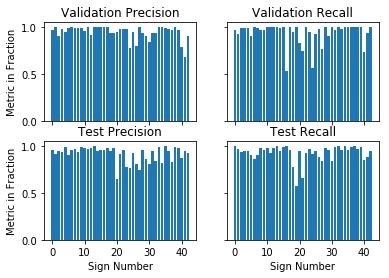

In [27]:
## Plot precision and recall

fig, axs = plt.subplots(2, 2, sharex='all', sharey='all')
axs[0,0].bar(range(len(unique_labels)), precision_valid)
axs[0,0].set_title('Validation Precision')
axs[0,1].bar(range(len(unique_labels)), recall_valid)
axs[0,1].set_title('Validation Recall')
axs[1,0].bar(range(len(unique_labels)), precision_test)
axs[1,0].set_title('Test Precision')
axs[1,1].bar(range(len(unique_labels)), recall_test)
axs[1,1].set_title('Test Recall')

for ax in axs.flat:
    ax.set(xlabel='Sign Number', ylabel='Metric in Fraction')
    
for ax in axs.flat:
    ax.label_outer()

plt.show()

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [28]:
import glob
base_folder = './traffic_sign_data/web_images'
filenames = glob.glob(base_folder+'/*_test.*')
filenames = [filenames[i] for i in np.argsort(filenames)]
test_images = []
for fname in filenames:
    img = cv2.imread(fname)
    img = cv2.resize(img, (32, 32), interpolation = cv2.INTER_AREA)
    test_images += [img]
test_images = np.array(test_images)
test_expect = np.array([1, 1, 2, 4, 12, 11, 14, 31, 31, 13])

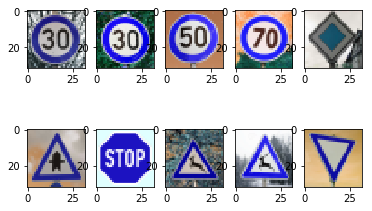

In [29]:
fig, axarr = plt.subplots(2,5)
for i in range(2):
    for j in range(5):
        axarr[i,j].imshow(test_images[i*5+j])

In [30]:
test_images_gray = np.zeros((len(test_images), 32, 32, 1))
for i in range(len(test_images)):
    test_images_gray[i,:,:,0] = cv2.cvtColor(test_images[i], cv2.COLOR_RGB2GRAY) 

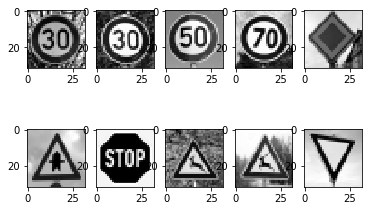

In [31]:
fig, axarr = plt.subplots(2,5)
for i in range(2):
    for j in range(5):
        axarr[i,j].imshow(test_images_gray[i*5+j].squeeze(), cmap='gray')

In [32]:
test_images_gray = normalize_data(test_images_gray)

In [33]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_data_accuracy = evaluate(test_images_gray, test_expect)
    predict = sess.run(prediction, feed_dict={x: test_images_gray, keep_prob: 1., channel_in: no_channels})
print("Web Images Accuracy = {:.3f}".format(test_data_accuracy))
print("Expected Result", test_expect)
print("Predicted Result", predict)

INFO:tensorflow:Restoring parameters from ./deonet3
Web Images Accuracy = 1.000
Expected Result [ 1  1  2  4 12 11 14 31 31 13]
Predicted Result [ 1  1  2  4 12 11 14 31 31 13]


### Analyze Performance

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [34]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    softmax_logits = sess.run(tf.nn.softmax(logits), feed_dict={x: test_images_gray, keep_prob: 1., channel_in: no_channels})
    top_k = sess.run(tf.nn.top_k(softmax_logits, k=5), feed_dict={x: test_images_gray, keep_prob: 1., channel_in: no_channels})
    print(top_k)

INFO:tensorflow:Restoring parameters from ./deonet3
TopKV2(values=array([[9.9995172e-01, 4.8031401e-05, 7.4138391e-08, 6.3614664e-08,
        4.5570570e-08],
       [1.0000000e+00, 2.6489408e-10, 6.7380351e-11, 8.7889968e-14,
        8.2421761e-15],
       [9.9967563e-01, 3.2283217e-04, 1.2162947e-06, 2.6570586e-07,
        1.0557997e-07],
       [9.9995887e-01, 4.0948853e-05, 1.4723841e-07, 3.6842316e-09,
        6.5360543e-11],
       [9.9999726e-01, 2.1899157e-06, 4.4193885e-07, 4.2742510e-08,
        2.5538741e-08],
       [9.9952161e-01, 4.7776703e-04, 5.9777801e-07, 4.1639634e-09,
        1.6166617e-09],
       [1.0000000e+00, 2.1631616e-10, 4.5356058e-12, 1.3328604e-14,
        8.6307390e-16],
       [9.9994278e-01, 5.0618743e-05, 3.5789005e-06, 2.9069656e-06,
        1.5310314e-07],
       [8.7425393e-01, 1.1135777e-01, 9.5354142e-03, 1.6763636e-03,
        1.4810705e-03],
       [1.0000000e+00, 3.8857629e-29, 1.9314873e-31, 6.8144598e-33,
        2.4760821e-37]], dtype=float32

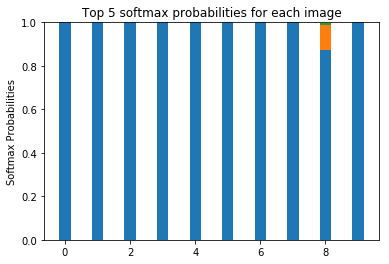

In [35]:
arr = np.array(top_k[0])

width = 0.35
labels = range(10)
y_offset = np.zeros(10)

fig, ax = plt.subplots()
for i in range(5):
    ax.bar(labels, arr.T[i], width, bottom=y_offset)
    y_offset = y_offset + arr.T[i]

ax.set_ylabel('Softmax Probabilities')
ax.set_title('Top 5 softmax probabilities for each image')

plt.show()

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can better understand what the weights of a neural network look like by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [36]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input, keep_prob: 1., channel_in: no_channels})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

INFO:tensorflow:Restoring parameters from ./deonet3


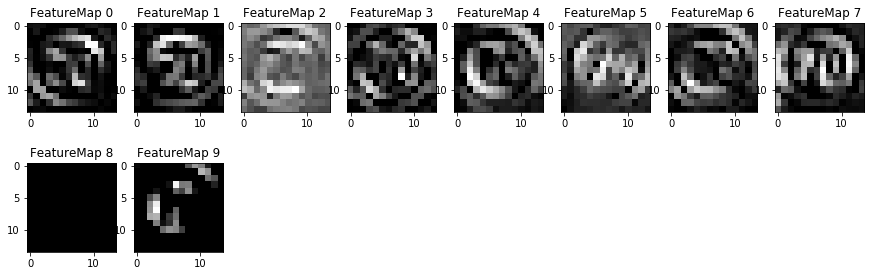

In [38]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    image = test_images_gray[3]
    image = np.expand_dims(image, axis=0)
    outputFeatureMap(image, conv1)